# **Import and clean data**

Table ADMISSIONS and Table NOTEEVENT are the two tables that will be used in this project. These two tables were uploaded from a.CSV file in the mimic III database to Google Drive and then imported by the mounted Drive in the Jupyter Notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')
table_A = "drive/My Drive/Msc project/ADMISSIONS.csv"
table_N = "drive/My Drive/Msc project/NOTEEVENTS.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import ADMISSIONS table

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_adm = pd.read_csv(table_A)
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [5]:
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

## Get the next admission date if it exists

Take the data for 'NEXT_ADMITTIME time' and sort it in chronological order

In [6]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)


df_adm.loc[df_adm.SUBJECT_ID == 222,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
286,222,2137-07-15 15:31:00,EMERGENCY
287,222,2141-02-18 23:10:00,EMERGENCY
288,222,2142-06-11 07:15:00,ELECTIVE
289,222,2142-06-23 05:02:00,EMERGENCY
290,222,2143-02-16 11:20:00,EMERGENCY


In [7]:
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

df_adm.loc[df_adm.SUBJECT_ID == 222,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
286,222,2137-07-15 15:31:00,EMERGENCY,2141-02-18 23:10:00,EMERGENCY
287,222,2141-02-18 23:10:00,EMERGENCY,2142-06-11 07:15:00,ELECTIVE
288,222,2142-06-11 07:15:00,ELECTIVE,2142-06-23 05:02:00,EMERGENCY
289,222,2142-06-23 05:02:00,EMERGENCY,2143-02-16 11:20:00,EMERGENCY
290,222,2143-02-16 11:20:00,EMERGENCY,NaT,NaN


Because the goal of this project is trying to predict unplanned readmissions, so ELECTIVE type need to be cleaned in next admission

In [8]:
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

df_adm.loc[df_adm.SUBJECT_ID == 222,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
286,222,2137-07-15 15:31:00,EMERGENCY,2141-02-18 23:10:00,EMERGENCY
287,222,2141-02-18 23:10:00,EMERGENCY,NaT,NaN
288,222,2142-06-11 07:15:00,ELECTIVE,2142-06-23 05:02:00,EMERGENCY
289,222,2142-06-23 05:02:00,EMERGENCY,2143-02-16 11:20:00,EMERGENCY
290,222,2143-02-16 11:20:00,EMERGENCY,NaT,NaN


Now we need to backfill in the values that we removed.


In [9]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

df_adm.loc[df_adm.SUBJECT_ID == 222,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
286,222,2137-07-15 15:31:00,EMERGENCY,2141-02-18 23:10:00,EMERGENCY
287,222,2141-02-18 23:10:00,EMERGENCY,2142-06-23 05:02:00,EMERGENCY
288,222,2142-06-11 07:15:00,ELECTIVE,2142-06-23 05:02:00,EMERGENCY
289,222,2142-06-23 05:02:00,EMERGENCY,2143-02-16 11:20:00,EMERGENCY
290,222,2143-02-16 11:20:00,EMERGENCY,NaT,NaN


## calculate Days until next admission


In [10]:
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)
df_adm.loc[df_adm.SUBJECT_ID == 222,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE','DAYS_NEXT_ADMIT']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
286,222,2137-07-15 15:31:00,EMERGENCY,2141-02-18 23:10:00,EMERGENCY,1312.465278
287,222,2141-02-18 23:10:00,EMERGENCY,2142-06-23 05:02:00,EMERGENCY,486.550000
288,222,2142-06-11 07:15:00,ELECTIVE,2142-06-23 05:02:00,EMERGENCY,3.688889
289,222,2142-06-23 05:02:00,EMERGENCY,2143-02-16 11:20:00,EMERGENCY,229.743056
290,222,2143-02-16 11:20:00,EMERGENCY,NaT,NaN,NaN


## Import NOTEEVENTS table

In [11]:
df_notes = pd.read_csv(table_N)
df_notes.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


'TEXT' is the important data for text mining in this project so the first data is printed out for display.

In [12]:
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

Because dates and PHI have been converted for confidentiality, and there are some symbols mixed in between. So in this part of data the discharge summary was selected for text mining, and other data that needs to be used will be consolidated.

In [13]:
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
print(df_notes_dis_sum)

       ROW_ID  ...                                               TEXT
0         174  ...  Admission Date:  [**2151-7-16**]       Dischar...
1         175  ...  Admission Date:  [**2118-6-2**]       Discharg...
2         176  ...  Admission Date:  [**2119-5-4**]              D...
3         177  ...  Admission Date:  [**2124-7-21**]              ...
4         178  ...  Admission Date:  [**2162-3-3**]              D...
...       ...  ...                                                ...
60411   59608  ...  Name:  [**Known lastname 18321**],[**Known fir...
60412   59609  ...  Name:  [**Known lastname 2706**], [**Known fir...
60413   59621  ...  Name:  [**Known lastname 18357**]-[**Known las...
60414   59622  ...  Name:  [**Known lastname **],[**Known firstnam...
60415   59623  ...  Name:  [**Known lastname 12459**],[**Known fir...

[59652 rows x 11 columns]


In [14]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'
print(df_notes_dis_sum_last)

       SUBJECT_ID  ...                                               TEXT
0               3  ...  Admission Date:  [**2101-10-20**]     Discharg...
1               4  ...  Admission Date:  [**2191-3-16**]     Discharge...
2               6  ...  Admission Date: [**2175-5-30**]        Dischar...
3               9  ...  Name:  [**Known lastname 10050**], [**Known fi...
4              10  ...  Admission Date:  [**2103-6-28**]       Dischar...
...           ...  ...                                                ...
52721       99985  ...  Admission Date:  [**2181-1-27**]              ...
52722       99991  ...  Admission Date:  [**2184-12-24**]             ...
52723       99992  ...  Admission Date:  [**2144-7-25**]              ...
52724       99995  ...  Admission Date:  [**2147-2-8**]              D...
52725       99999  ...  Admission Date:  [**2117-12-30**]             ...

[52726 rows x 11 columns]


## Merge data sets

In [15]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'
 
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

# **Set up training dataset, test dataset valid dataset**

In [16]:
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

In [17]:
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4184): 0.5


In [18]:
from keras.utils import np_utils

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
Y_train = np_utils.to_categorical(y_train)
Y_valid = np_utils.to_categorical(y_valid)

# **Preprocess text data**

In [19]:
import string
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
df_train.TEXT.iloc[0]

"Admission Date:  [**2144-5-6**]              Discharge Date:   [**2144-5-12**]\n\nDate of Birth:  [**2096-7-8**]             Sex:   M\n\nService: CARDIOTHORACIC\n\nAllergies:\nZyban\n\nAttending:[**First Name3 (LF) 2969**]\nChief Complaint:\nStage IIIB (T4) carcinoma of the\nright lung.\n\n\nMajor Surgical or Invasive Procedure:\ns/p median sternotomy for mediastinal mass w/ gortex to SVC.\n\n\nHistory of Present Illness:\nMr. [**Known lastname 8878**] is a 48-year-old gentleman with\nbiopsy-proven T4 carcinoma of the right upper lobe presenting\na superior vena caval syndrome. He received induction\nchemoradiotherapy with an excellent response and no evidence\nfor distant disease. He had adequate functional reserve, and\ngiven his youth and good performance status, an\naggressive approach to resect the disease and reconstruct his\ncentral veins was planned for this admission.\n\nPast Medical History:\n-Stage IIIB (T4) NSCLCA\n-s/p RUL lobectomy en bloc w/ SVC and brachiocephalic vein

In [21]:
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [22]:
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)


In [23]:
df_train.TEXT.iloc[0]

"Admission Date:  [**2144-5-6**]              Discharge Date:   [**2144-5-12**]  Date of Birth:  [**2096-7-8**]             Sex:   M  Service: CARDIOTHORACIC  Allergies: Zyban  Attending:[**First Name3 (LF) 2969**] Chief Complaint: Stage IIIB (T4) carcinoma of the right lung.   Major Surgical or Invasive Procedure: s/p median sternotomy for mediastinal mass w/ gortex to SVC.   History of Present Illness: Mr. [**Known lastname 8878**] is a 48-year-old gentleman with biopsy-proven T4 carcinoma of the right upper lobe presenting a superior vena caval syndrome. He received induction chemoradiotherapy with an excellent response and no evidence for distant disease. He had adequate functional reserve, and given his youth and good performance status, an aggressive approach to resect the disease and reconstruct his central veins was planned for this admission.  Past Medical History: -Stage IIIB (T4) NSCLCA -s/p RUL lobectomy en bloc w/ SVC and brachiocephalic veins resection and [**Doctor Last 

In [24]:
def clean_text(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t).split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text

In [25]:
df_train['TEXT'] = df_train['TEXT'].map(lambda x: clean_text(x))
df_valid['TEXT'] = df_valid['TEXT'].map(lambda x: clean_text(x))
df_test['TEXT'] = df_test['TEXT'].map(lambda x: clean_text(x))

In [26]:
df_train.TEXT.iloc[0]

'admission date discharge date date birth sex service cardiothoracic allergies zyban attending first name chief complaint stage iiib carcinoma right lung major surgical invasive procedure median sternotomy mediastinal mass gortex svc history present illness known lastname year old gentleman biopsy proven carcinoma right upper lobe presenting superior vena caval syndrome received induction chemoradiotherapy excellent response evidence distant disease adequate functional reserve given youth good performance status aggressive approach resect disease reconstruct central veins planned admission past medical history stage iiib nsclca rul lobectomy bloc svc brachiocephalic veins resection doctor last name tex reconstruction svc brachiocephalic veins radiation chemotherapy social history history ppd tobacco use patient lives partner location works company sells scientific research equipment family history notable extensive cad multiple relatives including father age physical exam general well 

### Build a Tokenizer to pre-processing text by serializing and vectorizing it

In [28]:
from keras.preprocessing import sequence, text
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

tokenizer  = Tokenizer(num_words=400000)


tokenizer.fit_on_texts(df_train.TEXT)
df_train_seq = tokenizer.texts_to_sequences(df_train.TEXT)
df_valid_seq = tokenizer.texts_to_sequences(df_valid.TEXT)


X_train = sequence.pad_sequences(df_train_seq, maxlen=maxlen)
X_valid = sequence.pad_sequences(df_valid_seq, maxlen=maxlen)

# **Buliding LSTM model and Training it**

In [27]:
max_features = 40000
maxlen = 4000
embed_size = 100
batch_size = 100
epochs_size = 10

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Embedding(max_features, embed_size, input_length=maxlen , trainable=False))
model.add(LSTM(32, recurrent_dropout=0.1))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))
model.summary()
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
model_train = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs_size,
          validation_data=(X_valid, Y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4000, 100)         4000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,019,266
Trainable params: 19,266
Non-trainable params: 4,000,000
_______________________________________

# **Performance Metric**

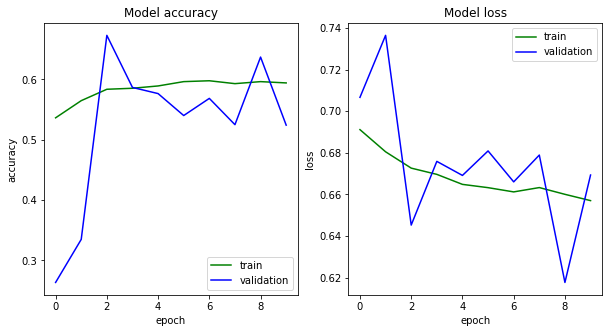

In [37]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(model_train.history['acc'], c='g', label='train')
plt.plot(model_train.history['val_acc'], c='b', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model accuracy')

plt.subplot(122)
plt.plot(model_train.history['loss'], c='g', label='train')
plt.plot(model_train.history['val_loss'], c='b', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model loss')

plt.show()

In [33]:
def calc_accuracy(y_actual, y_pred, thresh):
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return sum((y_actual == 1)) /len(y_actual)

Train AUC:0.647
Valid AUC:0.630
Train accuracy:0.604
Valid accuracy:0.544
Train recall:0.653
Valid recall:0.664
Train precision:0.595
Valid precision:0.080
Train specificity:0.555
Valid specificity:0.537
Train prevalence:0.500
Valid prevalence:0.057


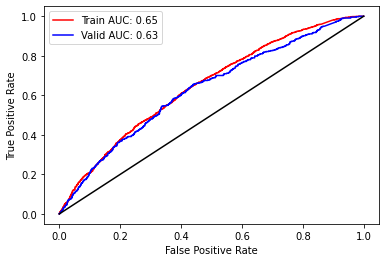

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()